# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

1. Download the Solar Sunspot Dataset

In [2]:
# Download dataset (monthly sunspot data)
filePath = 'sunspot_data.csv'
data = pd.read_csv(filePath)

In [3]:
# Display the first few rows
data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [4]:
# Filter out rows with invalid sunspot data (e.g., where "Number of Sunspots" is -1)
filtered_data = data[data['Number of Sunspots'] >= 0]

# Use only the "Number of Sunspots" column for the RNN
sunspots = filtered_data['Number of Sunspots'].values

# Display first few rows to check the data
filtered_data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
7,7,1818,1,8,1818.021,65,10.2,1,1
12,12,1818,1,13,1818.034,37,7.7,1,1
16,16,1818,1,17,1818.045,77,11.1,1,1
17,17,1818,1,18,1818.048,98,12.6,1,1
18,18,1818,1,19,1818.051,105,13.0,1,1


In [5]:
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Filtered data shape: (70471, 9)
Sunspots shape: (70471,)


2. Plot the Dataset Using Matplotlib

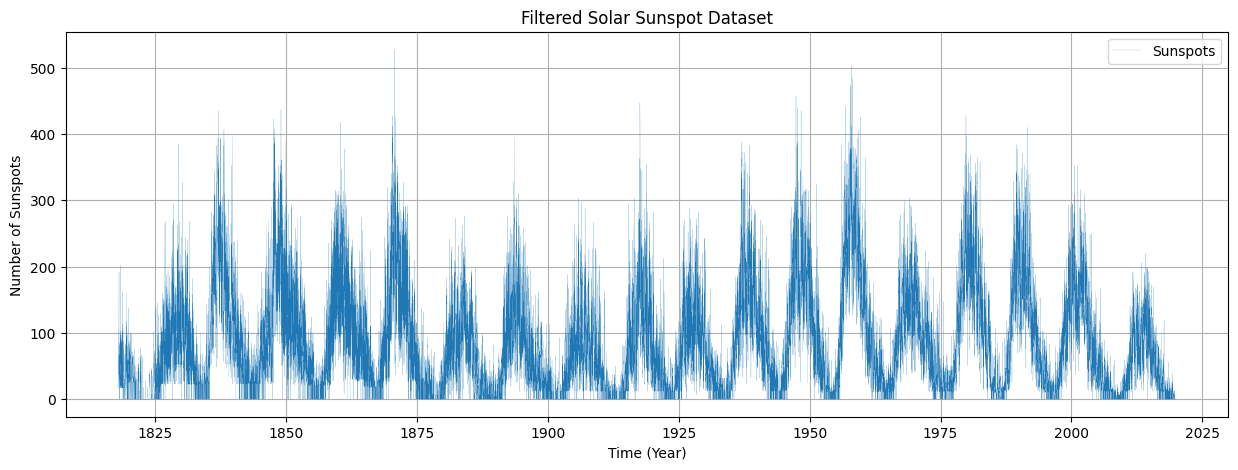

In [6]:
# Plot the dataset
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Date In Fraction Of Year'], sunspots, label='Sunspots', linewidth = 0.1)
plt.title('Filtered Solar Sunspot Dataset')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
len(filtered_data)

70471

In [8]:
filtered_data.shape

(70471, 9)

3. Select Window Number and Prepare Data for the RNN

Next, define a window size (i.e., how many time steps you want to look back) and prepare the data:

In [9]:
# Define window size (how many time steps to look back)
window_size = 12  # 12 months (or time steps)

In [10]:
# Function to create a windowed dataset
def create_windowed_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [11]:
# Create X and y for the RNN
X, y = create_windowed_dataset(sunspots, window_size)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70459, 12), y shape: (70459,)


4. Implement the RNN

Initialize weights, biases, and perform the forward pass:

In [12]:
# Initialize the parameters for the RNN
hidden_size = 10
input_size = window_size

In [13]:
# Initialize weights and biases
np.random.seed(42)
W_xh = np.random.randn(hidden_size, input_size) * 0.01
W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
W_hy = np.random.randn(1, hidden_size) * 0.01
b_h = np.zeros((hidden_size, 1))
b_y = np.zeros((1, 1))

In [14]:
# Activation function
def relu(x):
    return np.maximum(0, x)

# Function to calculate MSE
def mean_squared_error(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

# Gradient clipping function
def clip_gradient(grad, threshold):
    return np.clip(grad, -threshold, threshold)

# Forward pass
def forward(X):
    hidden_state = np.zeros((hidden_size, 1))  # Initialize hidden state
    X = X.reshape(-1, 1)  # Reshape X to (input_size, 1)
    hidden_state = relu(np.dot(W_xh, X) + np.dot(W_hh, hidden_state) + b_h)
    output = np.dot(W_hy, hidden_state) + b_y
    return output, hidden_state

5. Train the RNN and Track Error

The next step is to train the RNN and track the error across epochs:

In [15]:
# Training loop
epochs = 10
learning_rate = 0.0001      # Reduce learning rate
errors = []

In [16]:
for epoch in range(epochs):
    total_loss = 0
    for i in range(X.shape[0]):
        # Forward pass
        y_pred, hidden_state = forward(X[i])

        # Compute the loss (MSE)
        loss = mean_squared_error(y_pred, y[i])
        total_loss += loss

        # Backpropagation
        dL_dy = 2 * (y_pred - y[i])

        # Gradient of weights and biases
        dW_hy = np.dot(dL_dy, hidden_state.T)
        db_y = dL_dy

        # Backpropagate through hidden layers
        d_hidden = np.dot(W_hy.T, dL_dy)

        # Calculate weight gradients
        dW_xh = np.dot(d_hidden, X[i].reshape(1, -1))
        dW_hh = np.dot(d_hidden, hidden_state.T)
        db_h = d_hidden

        # Clip gradients to avoid exploding gradients
        dW_xh = clip_gradient(dW_xh, threshold=1.0)
        dW_hh = clip_gradient(dW_hh, threshold=1.0)
        dW_hy = clip_gradient(dW_hy, threshold=1.0)
        db_h = clip_gradient(db_h, threshold=1.0)
        db_y = clip_gradient(db_y, threshold=1.0)

        # Update weights and biases
        W_xh -= learning_rate * dW_xh
        W_hh -= learning_rate * dW_hh
        W_hy -= learning_rate * dW_hy
        b_h -= learning_rate * db_h
        b_y -= learning_rate * db_y

    # Average loss for the epoch
    avg_loss = total_loss / X.shape[0]
    errors.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')

Epoch 1/10, Loss: 1036.3424202174679
Epoch 2/10, Loss: 650.9091509202162
Epoch 3/10, Loss: 581.7594900307895
Epoch 4/10, Loss: 560.1544568582686
Epoch 5/10, Loss: 554.7942044300622
Epoch 6/10, Loss: 565.1553703181812
Epoch 7/10, Loss: 600.252686628003
Epoch 8/10, Loss: 604.3893924614611
Epoch 9/10, Loss: 594.4974132511677
Epoch 10/10, Loss: 620.9589134481122


6. Plot error progress

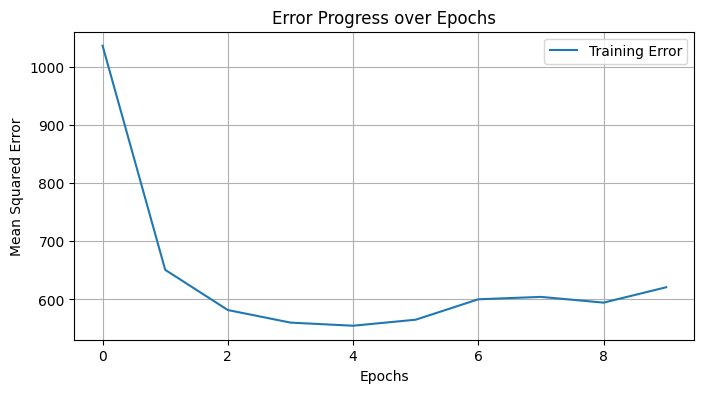

In [17]:
# Plot error progress
plt.figure(figsize=(8, 4))
plt.plot(errors, label='Training Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Error Progress over Epochs')
plt.legend()
plt.grid(True)
plt.show()

7. Generate predictions for the dataset

In [18]:
predictions = []
for i in range(X.shape[0]):
    y_pred, _ = forward(X[i])
    predictions.append(y_pred.flatten()[0])

8. Plot original data and predictions

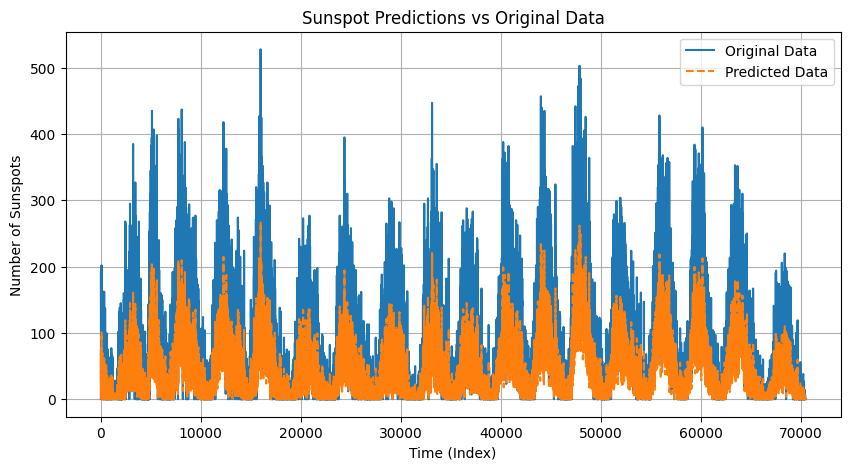

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(window_size, len(sunspots)), sunspots[window_size:], label='Original Data')
plt.plot(range(window_size, len(sunspots)), predictions, label='Predicted Data', linestyle='dashed')
plt.title('Sunspot Predictions vs Original Data')
plt.xlabel('Time (Index)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()